In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from statsmodels.graphics.gofplots import qqplot_2samples
from scipy.stats import chisquare
from scipy.stats import chi2
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')

# Spring

In [2]:
spring_amiata = pd.read_csv('acea-water-prediction/Water_Spring_Amiata.csv')
spring_lupa = pd.read_csv('acea-water-prediction/Water_Spring_Lupa.csv')
spring_madonna = pd.read_csv('acea-water-prediction/Water_Spring_Madonna_di_Canneto.csv')

In [3]:
spring_amiata.dropna(how = 'all',inplace = True)
spring_lupa.dropna(how = 'all',inplace = True)
spring_madonna.dropna(how = 'all',inplace = True)
spring_amiata['Date'] = pd.to_datetime(spring_amiata['Date'], dayfirst = True)
spring_lupa['Date'] = pd.to_datetime(spring_lupa['Date'], dayfirst = True)
spring_madonna['Date'] = pd.to_datetime(spring_madonna['Date'], dayfirst = True)
spring_amiata.set_index('Date', inplace = True)
spring_lupa.set_index('Date', inplace = True)
spring_madonna.set_index('Date', inplace = True)


In [4]:
#Returns a dataframe
#groups by season so 12 is winter 3 is spring 6 is summer 9 is autumn

def get_season_nogroup(df):
    temp = df.groupby(pd.Grouper(key = 'Date', freq = 'BQS-MAR')).mean().reset_index()
    temp['Season'] = pd.DatetimeIndex(temp['Date']).month
    return temp

In [5]:
def get_season(df):
    temp = df.groupby(pd.Grouper(key = 'Date', freq = 'BQS-MAR')).mean().reset_index()
    temp['Season'] = pd.DatetimeIndex(temp['Date']).month
    temp = temp.groupby('Season').mean().reset_index()
    #temp['Season'].replace(to_replace = {12: 'Winter', 3: 'Spring', 6: 'Summer', 9: 'Autumn'}, inplace=True)
    return temp

In [6]:
#Returns a df
#performs ols trying to predict the y

def get_pi(x, y, a, df):
    mod = sm.OLS(y, x)
    res = mod.fit()
    predictions = res.get_prediction(x)
    pi = predictions.summary_frame(alpha = a)
    pi['Season'] = x
    return pi.iloc[:, np.r_[0:4, -1]]

In [7]:
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [8]:
#Returns an int
#Uses the pca components to do linear regression and returns the RMSE

def lr(X, y, num_components):
    #Time series test train split
    tscv = TimeSeriesSplit()
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    #Using pca components
    pca = PCA(n_components = num_components)
    X_pca = pca.fit_transform(X_train)
    X_pca_test = pca.fit_transform(X_test)
    lm = LinearRegression()
    model = lm.fit(X_pca, y_train)
    y_pred = model.predict(X_pca_test)
    return round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3)

In [32]:
def lr_nopca(X, y):
    tscv = TimeSeriesSplit()
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3)

## Amiata

In [9]:
spring_amiata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7487 entries, 2000-01-01 to 2020-06-30
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Rainfall_Castel_del_Piano              6291 non-null   float64
 1   Rainfall_Abbadia_S_Salvatore           3586 non-null   float64
 2   Rainfall_S_Fiora                       2633 non-null   float64
 3   Rainfall_Laghetto_Verde                2865 non-null   float64
 4   Rainfall_Vetta_Amiata                  2212 non-null   float64
 5   Depth_to_Groundwater_S_Fiora_8         3569 non-null   float64
 6   Depth_to_Groundwater_S_Fiora_11bis     3594 non-null   float64
 7   Depth_to_Groundwater_David_Lazzaretti  3242 non-null   float64
 8   Temperature_Abbadia_S_Salvatore        3583 non-null   float64
 9   Temperature_S_Fiora                    7487 non-null   float64
 10  Temperature_Laghetto_Verde             3604 non-null  

Above, we see that there are a varying amount of missing data. With a total of 7487 observations, all of the variables are missing over half of the observations, i.e missing 3500 or more days during the study. Because we want to study the relationship between the variables and the flow rate, we drop any missing observations in the flow rate variables because a missing data in the flow rate variable is meaningless, as we are unable to study any relationship. 

In [10]:
spring_amiata.dropna(subset=['Flow_Rate_Bugnano', 'Flow_Rate_Arbure', 'Flow_Rate_Ermicciolo', 'Flow_Rate_Galleria_Alta'], 
                     how = 'all', inplace = True)
spring_amiata.reset_index(inplace = True)

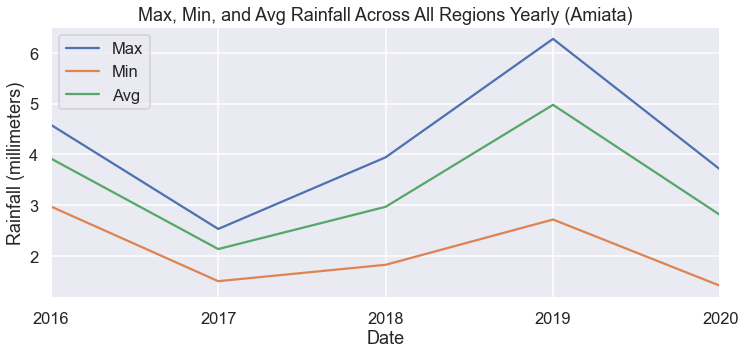

In [11]:
temp = spring_amiata.dropna().groupby(pd.Grouper(key = 'Date', freq = 'YS')).mean().reset_index() #grouping by years
temp['Season'] = pd.DatetimeIndex(temp['Date']).month
temp['max'] = temp.iloc[:,:6].max(axis = 1)
temp['min'] = temp.iloc[:,:6].min(axis = 1)
temp['avg'] = temp.iloc[:,:6].mean(axis = 1)

fig, ax = plt.subplots(figsize=(12, 5))

temp.plot(kind = 'line', x = 'Date', y = 'max', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'min', ax = ax)
temp.plot(kind = 'line', x = 'Date', y = 'avg', ax = ax)
ax.legend(labels = ['Max', 'Min', 'Avg'])
ax.set_title('Max, Min, and Avg Rainfall Across All Regions Yearly (Amiata)')
ax.set_ylabel('Rainfall (millimeters)')

plt.show()

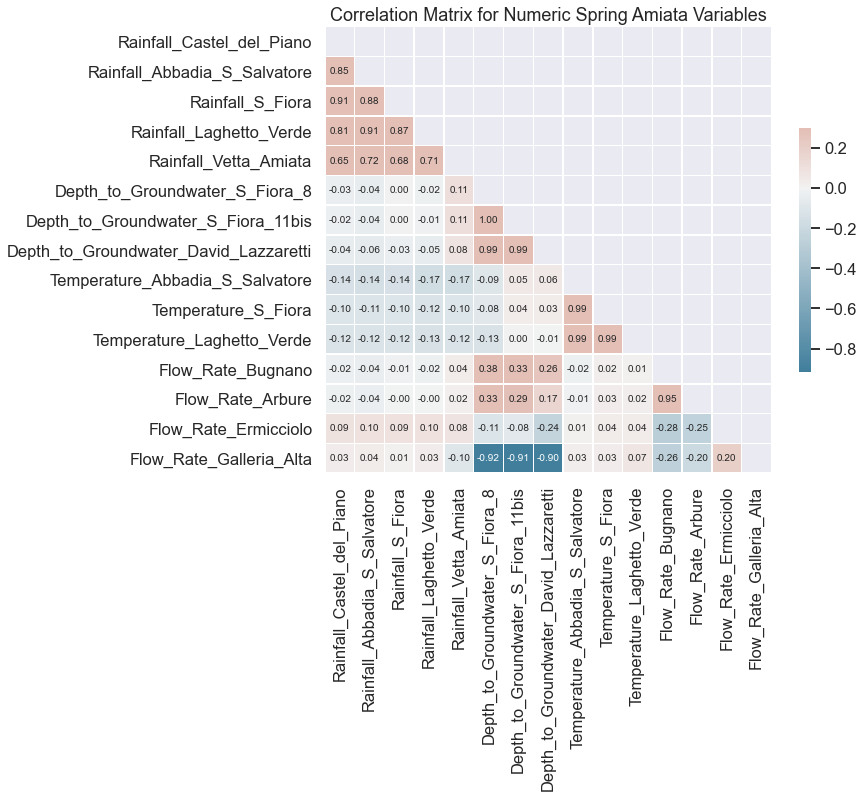

In [12]:
fig, ax = plt.subplots(figsize=(10, 9))
corr = spring_amiata.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) #to cover upper triangular
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5}, annot = True, fmt = '.2f', ax = ax, annot_kws={"size": 10})
ax.set_title('Correlation Matrix for Numeric Spring Amiata Variables')
plt.show()

In [13]:
#amiata = get_season_nogroup(spring_amiata.dropna())

a_pi = pd.DataFrame(index = spring_amiata.columns[1:12], columns = ['Spring', 'Summer', 'Autumn', 'Winter'])
a_pi.index.name = 'Region'

for i in range(1, 12):
    amiata = spring_amiata.dropna(subset = [spring_amiata.columns[i]])
    amiata = get_season_nogroup(amiata)
    amiata = amiata.fillna(0)
    x = amiata['Season']
    y = amiata.iloc[:, i]
    temp = get_pi(x, y, 0.05, amiata)
    temp = temp.groupby('Season').mean().reset_index()
    a_pi.iloc[i - 1,:] = round(temp.iloc[:,3:5], 3).values.tolist()

cols = list(a_pi.columns)
cols = [cols[-1]] + cols[:-1]
a_pi = a_pi[cols]
print('Prediction Intervals for Amiata Predictors')
a_pi

Prediction Intervals for Amiata Predictors


,Winter,Spring,Summer,Autumn
Region,,,,
Rainfall_Castel_del_Piano,"[2.541, 5.037]","[0.635, 1.259]","[1.27, 2.519]","[1.906, 3.778]"
Rainfall_Abbadia_S_Salvatore,"[3.633, 7.172]","[0.908, 1.793]","[1.817, 3.586]","[2.725, 5.379]"
Rainfall_S_Fiora,"[3.31, 7.065]","[0.827, 1.766]","[1.655, 3.533]","[2.482, 5.299]"
Rainfall_Laghetto_Verde,"[3.996, 7.972]","[0.999, 1.993]","[1.998, 3.986]","[2.997, 5.979]"
Rainfall_Vetta_Amiata,"[2.986, 5.0]","[0.747, 1.25]","[1.493, 2.5]","[2.24, 3.75]"
Depth_to_Groundwater_S_Fiora_8,"[-54.596, -29.134]","[-13.649, -7.284]","[-27.298, -14.567]","[-40.947, -21.851]"
Depth_to_Groundwater_S_Fiora_11bis,"[-74.04, -39.55]","[-18.51, -9.888]","[-37.02, -19.775]","[-55.53, -29.663]"
Depth_to_Groundwater_David_Lazzaretti,"[-488.26, -323.373]","[-122.065, -80.843]","[-244.13, -161.687]","[-366.195, -242.53]"
Temperature_Abbadia_S_Salvatore,"[7.389, 19.884]","[1.847, 4.971]","[3.694, 9.942]","[5.541, 14.913]"


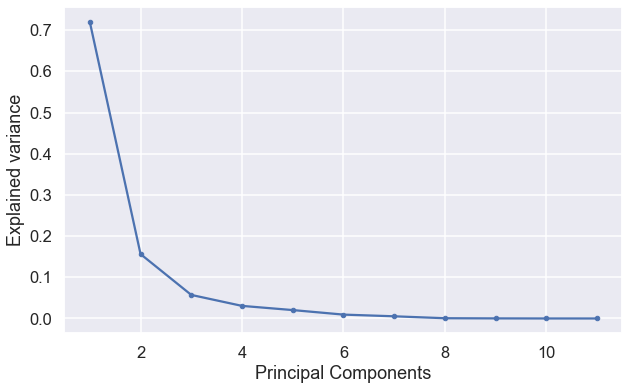

In [14]:
#PCA dimensionality reduction

array = spring_amiata.dropna().values
X = array[:,1:12]

pca = PCA(n_components = 11)
fit = pca.fit(X)
temp = pd.DataFrame(pca.explained_variance_ratio_, columns = ['Variance'], index = list(range(1, len(pca.explained_variance_ratio_) + 1)))

fig, ax = plt.subplots(figsize=(10, 6))
temp.plot(kind = 'line', style='.-', legend = False, ax = ax)
plt.xlabel('Principal Components')
plt.ylabel('Explained variance')

plt.show()

In [15]:
array = spring_amiata.dropna().values
X = array[:,1:11]
y = array[:, 12]
print('RMSE when predicting the Flow_Rate_Bugnano:', lr(X, y, 6))

X = array[:,1:11]
y = array[:, 13]
print('RMSE when predicting the Flow_Rate_Arbure:', lr(X, y, 6))

X = array[:,1:11]
y = array[:, 14]
print('RMSE when predicting the Flow_Rate_Ermicciolo:', lr(X, y, 6))

X = array[:,1:11]
y = array[:, 15]
print('RMSE when predicting the Flow_Rate_Galleria_Alta:', lr(X, y, 6))

RMSE when predicting the Flow_Rate_Bugnano: 0.057
RMSE when predicting the Flow_Rate_Arbure: 0.44
RMSE when predicting the Flow_Rate_Ermicciolo: 1.886
RMSE when predicting the Flow_Rate_Galleria_Alta: 1.133


## Lupa and Madonna Di Canneto

In [28]:
spring_lupa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            3817 non-null   datetime64[ns]
 1   Rainfall_Terni  3817 non-null   float64       
 2   Flow_Rate_Lupa  3817 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 89.6 KB


In [29]:
spring_madonna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3104 entries, 0 to 3103
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          3104 non-null   datetime64[ns]
 1   Rainfall_Settefrati           2557 non-null   float64       
 2   Temperature_Settefrati        2557 non-null   float64       
 3   Flow_Rate_Madonna_di_Canneto  1387 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 97.1 KB


In [18]:
#Dropping values

spring_lupa.dropna(inplace = True)
spring_lupa.reset_index(inplace = True)

spring_madonna.reset_index(inplace = True)

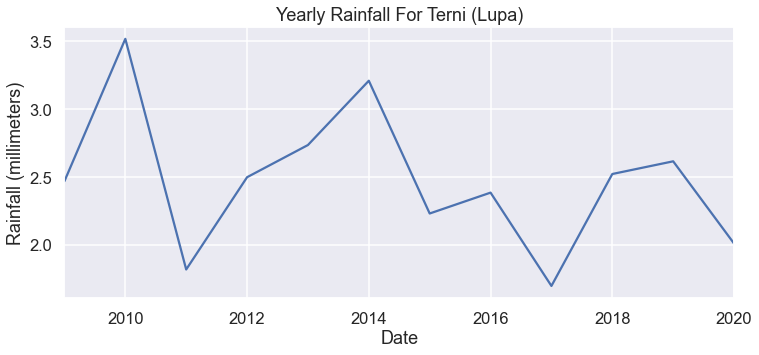

In [19]:
temp = spring_lupa.dropna().groupby(pd.Grouper(key = 'Date', freq = 'YS')).mean().reset_index() #grouping by years
temp['Season'] = pd.DatetimeIndex(temp['Date']).month

fig, ax = plt.subplots(figsize=(12, 5))

temp.plot(kind = 'line', x = 'Date', y = 'Rainfall_Terni', ax = ax, legend = False)
ax.set_title('Yearly Rainfall For Terni (Lupa)')
ax.set_ylabel('Rainfall (millimeters)')

plt.show()

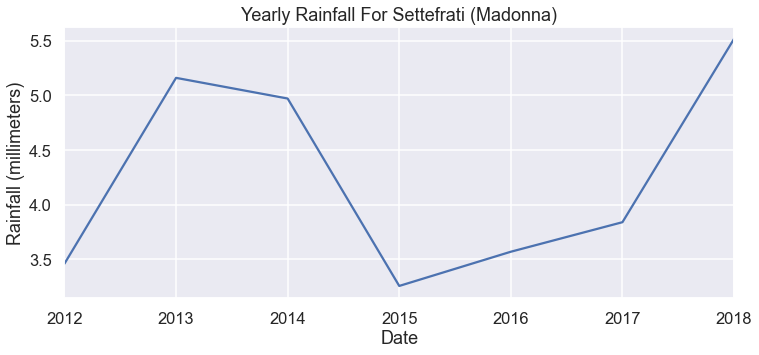

In [20]:
temp = spring_madonna.dropna(subset=['Rainfall_Settefrati'])
temp = temp.groupby(pd.Grouper(key = 'Date', freq = 'YS')).mean().reset_index() #grouping by years
temp['Season'] = pd.DatetimeIndex(temp['Date']).month

fig, ax = plt.subplots(figsize=(12, 5))

temp.plot(kind = 'line', x = 'Date', y = 'Rainfall_Settefrati', ax = ax, legend = False)
ax.set_title('Yearly Rainfall For Settefrati (Madonna)')
ax.set_ylabel('Rainfall (millimeters)')

plt.show()

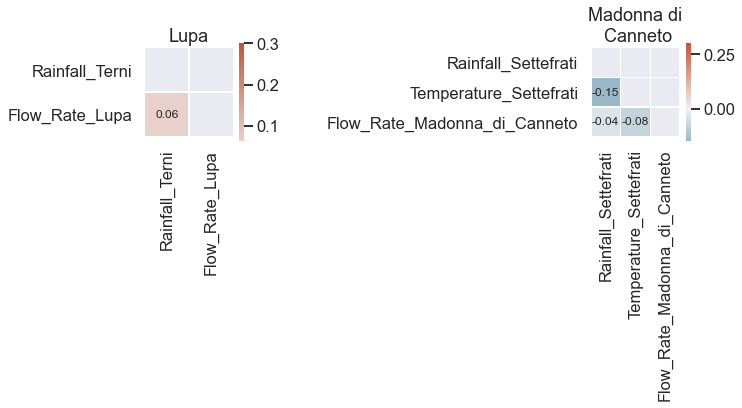

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
plt.subplots_adjust(wspace = 3)


corr = spring_lupa.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) #to cover upper triangular
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .3}, annot = True, fmt = '.2f', ax = ax[0], annot_kws={"size": 12})
ax[0].set_title('Lupa')

corr = spring_madonna.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) #to cover upper triangular
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .3}, annot = True, fmt = '.2f', ax = ax[1], annot_kws={"size": 12}, )
ax[1].set_title('Madonna di\n Canneto')


plt.show()

In [22]:
lupa = get_season_nogroup(spring_lupa.dropna())

l_pi = pd.DataFrame(columns = spring_lupa.columns[1:2], index = [ 'Winter', 'Spring', 'Summer', 'Autumn'])
l_pi.index.name = 'Season'

for i in range(1, 2):
    x = lupa['Season']
    y = lupa.iloc[:, i]
    temp = get_pi(x, y, 0.05, lupa)
    temp = temp.groupby('Season').mean().reset_index()
    l_pi.iloc[:,i - 1] = round(temp.iloc[:,3:5], 3).values.tolist()
    
l_pi = l_pi.apply(np.roll, shift=1) #Calculated with 3, 6, 9, 12 3 being spring 9 being autumn

In [23]:
#Confidence Intervals
#Lupa
lupa = get_season_nogroup(spring_lupa.dropna())

l_pi = pd.DataFrame(columns = spring_lupa.columns[1:2], index = [ 'Winter', 'Spring', 'Summer', 'Autumn'])
l_pi.index.name = 'Season'

for i in range(1, 2):
    x = lupa['Season']
    y = lupa.iloc[:, i]
    temp = get_pi(x, y, 0.05, lupa)
    temp = temp.groupby('Season').mean().reset_index()
    l_pi.iloc[:,i - 1] = round(temp.iloc[:,3:5], 3).values.tolist()
    
l_pi = l_pi.apply(np.roll, shift=1) #Calculated with 3, 6, 9, 12 3 being spring 9 being autumn

#Madonna di Canneto
madonna = get_season_nogroup(spring_madonna.dropna())
madonna = madonna.fillna(0)

m_pi = pd.DataFrame(columns = spring_madonna.columns[1:3], index = [ 'Winter', 'Spring', 'Summer', 'Autumn'])
m_pi.index.name = 'Season'

for i in range(1, 3):
    x = madonna['Season']
    y = madonna.iloc[:, i]
    temp = get_pi(x, y, 0.05, madonna)
    temp = temp.groupby('Season').mean().reset_index()
    m_pi.iloc[:,i - 1] = round(temp.iloc[:,3:5], 3).values.tolist()
    
m_pi = m_pi.apply(np.roll, shift=1) #Calculated with 3, 6, 9, 12 3 being spring 9 being autumn

In [24]:
print('Prediction Intervals for Lupa (Left) Madonna di Canneto (Right) Predictors')
multi_table([l_pi, m_pi])

Prediction Intervals for Lupa (Left) Madonna di Canneto (Right) Predictors


In [43]:
array = spring_lupa.dropna().values
X = array[:,1]
y = array[:, 2]
X = X.reshape(-1, 1)
print('RMSE when predicting the Flow Rate of Lupa:', lr_nopca(X, y))

array = spring_madonna.dropna().values
X = array[:,1:3]
y = array[:, 3]
print('RMSE when predicting the Flow Rate of Madonna di Canneto:', lr(X, y, 2))

RMSE when predicting the Flow Rate of Lupa: 15.792
RMSE when predicting the Flow Rate of Madonna di Canneto: 18.652
